In [6]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')

import summa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Step 2. 데이터 전처리하기 (추상적 요약)

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [11]:
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


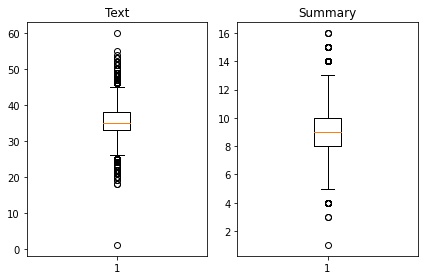

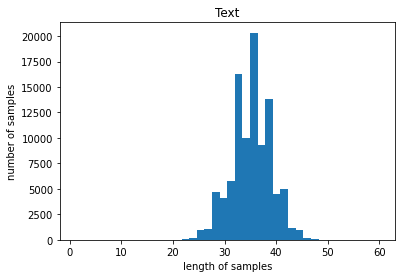

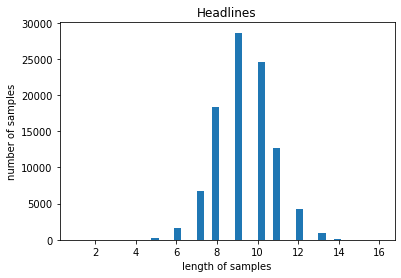

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 50
headlines_max_len = 10

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt=0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt+=1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(text_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 80280


In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42355 43617 69647 ... 31192   803 77319]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16056


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 64224
훈련 레이블의 개수 : 64224
테스트 데이터의 개수 : 16056
테스트 레이블의 개수 : 16056


In [27]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt, total_freq, rare_freq = 0,0,0

for key, value in src_tokenizer.word_counts.items():
    total_freq += value
    
    if (value < threshold):
        rare_cnt+=1
        rare_freq+=value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64988
등장 빈도가 6번 이하인 희귀 단어의 수: 44647
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20341
단어 집합에서 희귀 단어의 비율: 68.70037545392995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.020000141706787


In [29]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[196, 1187, 596, 51, 1, 3962, 2146, 2147, 351, 365, 204, 238, 1919, 376, 328, 130, 2146, 6305, 11614, 4077, 413, 2277, 18957, 196, 1, 1570, 10619, 67, 154, 48], [589, 889, 35, 10, 1691, 2833, 455, 2133, 1744, 8315, 2181, 804, 7460, 589, 96, 3288, 11615, 6, 24, 4812, 315, 589, 662, 10, 470, 2133, 1], [554, 689, 8613, 1616, 316, 2550, 1884, 2524, 5381, 36, 415, 157, 3312, 1625, 3245, 1324, 325, 4362, 1616, 18, 522, 662, 1045, 325, 181, 1, 1324, 325, 232, 16863, 1616]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28403
등장 빈도가 5번 이하인 희귀 단어의 수: 18920
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9483
단어 집합에서 희귀 단어의 비율: 66.61268175896913
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.712086634686499


In [33]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1408, 4949, 2474, 1601, 13, 43, 610, 8], [1, 271, 691, 36, 1272, 6065, 3, 377, 1771], [1, 4229, 230, 2642, 1656, 75, 9, 4759, 6], [1, 403, 199, 62, 3, 339, 133, 7, 248, 51], [1, 20, 3, 1188, 242, 755, 5, 2028, 692, 3679, 147]]
target
decoder  [[1408, 4949, 2474, 1601, 13, 43, 610, 8, 2], [271, 691, 36, 1272, 6065, 3, 377, 1771, 2], [4229, 230, 2642, 1656, 75, 9, 4759, 6, 2], [403, 199, 62, 3, 339, 133, 7, 248, 51, 2], [20, 3, 1188, 242, 755, 5, 2028, 692, 3679, 147, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 64224
훈련 레이블의 개수 : 64224
테스트 데이터의 개수 : 16055
테스트 레이블의 개수 : 16055


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [36]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector.shape

(300,)

In [37]:
word_vector_dim = 300

src_embedding_matrix = np.random.randn(src_vocab, word_vector_dim)

def get_vector(word):
    if word in word2vec:
        return word2vec[word]
    else:
        return None
i=0
for word, index in src_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        src_embedding_matrix[index-1] = vector_value
    i+=1
    if i == 9000:
        break

In [38]:
tar_embedding_matrix = np.random.randn(tar_vocab, word_vector_dim)

i=0
for word, index in tar_tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        tar_embedding_matrix[index-1] = vector_value
    i+=1
    if i == 9000:
        break

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab,
                   word_vector_dim,
                   embeddings_initializer=Constant(src_embedding_matrix),
                   input_length=text_max_len,
                   trainable=True)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab,
                   word_vector_dim,
                   embeddings_initializer=Constant(tar_embedding_matrix),
                   input_length=headlines_max_len,
                   trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 570368      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 570368      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
251/251 [==============================] - 32s 98ms/step - loss: 6.2332 - val_loss: 5.8525
Epoch 2/50
251/251 [==============================] - 24s 95ms/step - loss: 5.7383 - val_loss: 5.4150
Epoch 3/50
251/251 [==============================] - 24s 97ms/step - loss: 5.3035 - val_loss: 5.0761
Epoch 4/50
251/251 [==============================] - 25s 100ms/step - loss: 4.9849 - val_loss: 4.8558
Epoch 5/50
251/251 [==============================] - 26s 103ms/step - loss: 4.7292 - val_loss: 4.6950
Epoch 6/50
251/251 [==============================] - 26s 102ms/step - loss: 4.5153 - val_loss: 4.5257
Epoch 7/50
251/251 [==============================] - 25s 101ms/step - loss: 4.3290 - val_loss: 4.4232
Epoch 8/50
251/251 [==============================] - 26s 102ms/step - loss: 4.1655 - val_loss: 4.3359
Epoch 9/50
251/251 [==============================] - 26s 102ms/step - loss: 4.0226 - val_loss: 4.2709
Epoch 10/50
251/251 [==============================] - 25s 101ms/step - loss

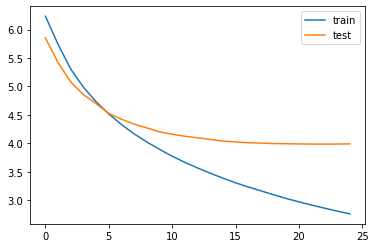

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : calling pm narendra modi democratically elected leader criticised aimim president asaduddin owaisi asked bjp cm said make us flee say anything pm proclaimed god earlier cm yogi adityanath said owaisi brother flee telangana like nizam bjp elected 
실제 요약 : has pm modi himself as god asks owaisi 
예측 요약 :  pm modi calls for remark on his resignation


원문 : government waived merchant discount rate debit card upi aadhaar based transactions next two years starting january rate charged merchant bank providing debit credit card services charges reimbursed government banks 
실제 요약 : no fees on debit card payments of up to 
예측 요약 :  aadhaar card can be mandatory for all customers uidai


원문 : uidai complaint newspaper tribune story alleged breach aadhaar data security act access uidai clarified official statement fir viewed targeting media shooting messenger uidai added absolutely breach aadhaar biometric database said 
실제 요약 : fir against over act of access uidai 
예측 요약 :  aadhaar data leak 

# Step 5. Summa을 이용해서 추출적 요약해보기

In [25]:
import requests
from summa.summarizer import summarize

In [26]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
s_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')  # data load

In [27]:
s_data.drop_duplicates(subset = ['text'], inplace=True) # 중복값 제거
s_data.dropna(axis=0, inplace=True)

In [28]:
s_data.loc[51,'headlines']

'Boeing sales cross $100bn for 1st time in its 102-yr history'

In [31]:
i=50
for text in s_data['text'][50:100]:
    s = summarize(text, words=8)
    if s != '':
        print('Summary:')
        print(i,s,'\n')
    i+=1

Summary:
59 Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it. 

Summary:
60 The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1. 

Summary:
70 "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. 

Summary:
78 "North Korean leaders view nuclear arms as critical to regime survival," he added. 

Summary:
79 Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added. 

Summary:
82 Tanya accused Perera of meeting country's Sports Minister to secure his place in the team. 

Summary:
84 PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman. 

Summary:
92 "This is an insult to [the] beauty of marriage," an Instagram user commented on her post. 

Summary:
98 He said the Opposition is thinking about leading the country but does not have a leader. 



In [36]:
s_data.iloc[84,1]

'Prime Minister Narendra Modi stopped his speech at the inauguration of the new terminal building at Surat airport after observing that a cameraman had fainted. PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman. "It\'s good that PM was paying attention to his surroundings during his speech," the cameraman later said from a hospital. '

- seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법
- 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding)
- 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

# 회고

text 지문과 headline으로 쓸 문장이 다르기 때문에 decoder와 encoder의 단어사전을 다르게 가져가는 게 특이했음

그리고 고정된 벡터에 정보를 압축하여 정보손실이 있을 수 있고, 본질적인 RNN의 문제점으로 Gradient vanishing이 있을 수 있다.

그래서 이를 해결하기 위해 Attention layer와 concat시키고 예측하는 시점마다 연관있는 데이터에 더 집중해서 encoder에 들어가는 문장을 다시 한번 검토할 수 있게 만들어준다고 한다.

이렇게 기본적인 것들만 해줘도 충분히 성능이 나오기는 했지만 인간의 욕심은 끝이 없다.

먼저 사전에 훈련된 embedding vector인 word2vec으로 초기 embedding 값을 설정해주고 다시 확인해보았다

- Absractive 요약

| index |구분 기호| Absractive 요약 | Extractive 요약|
|---|---|---|---|
| 9 | 실제요약 | infosys names ravi as co chairman post murthy row |Banned cricketer Sreesanth has told Supreme Court he initially confessed to Delhi Police about his alleged involvement in 2013 IPL spot-fixing scandal to escape continuous police torture. Sreesanth further said the bookie tried dragging him into spot-fixing but he didn\'t fall for it. Citing Sreesanth not informing BCCI about fixing approach, the apex court said Sreesanth\'s conduct "wasn\'t good".|
| 9 | 예측요약 |  infosys board appoints murthy as chairman | Sreesanth further said the bookie tried dragging him into spot-fixing but he didn't fall for it.
|||
|10 |실제요약 | taj mahal on indian culture bjp leader sangeet| The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1. The clarification came amid speculations that a full Budget may be presented during the session. The government recently assigned Piyush Goyal temporary additional charge of the Finance and Corporate Affairs ministries in the absence of Arun Jaitley, who is in the US for treatment.
| 10 | 예측요약 |  taj mahal bjp mla receives taj mahal | The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1.|
|||
| 30 | 실제요약 | youtube videos watched for million hours ceo
| 30 | 예측요약 |  youtube to let users share location on day
|||
| 32 | 실제요약 | anushka shares st official wedding video on marriage anniversary|Sri Lanka all-rounder Thisara Perera has written to Sri Lanka Cricket CEO Ashley de Silva, asking the board to intervene after ODI captain Lasith Malinga\'s wife Tanya targeted him on Facebook. Tanya accused Perera of meeting country\'s Sports Minister to secure his place in the team. "We\'ve become laughing stock of whole country...because of one person\'s personal vendetta," Perera wrote.
| 32 | 예측요약 |  anushka sharma shares video of anushka sharma|Tanya accused Perera of meeting country's Sports Minister to secure his place in the team.
|||
| 34 |실제요약 | ipl purple cap winner goes unsold for rd straight year |Prime Minister Narendra Modi stopped his speech at the inauguration of the new terminal building at Surat airport after observing that a cameraman had fainted. PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman. "It\'s good that PM was paying attention to his surroundings during his speech," the cameraman later said from a hospital.
| 34 |예측요약 |  ipl auction has lost ipl auction in ipl auction |PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman.


불용어와 결측치를 제거하면서 추출적요약과 추상적요약에 사용된 데이터의 index가 맞지않아 위 표의 한줄에 나온 두 요약은 서로 다른 기사를 요약한 것이다.

추상적 요약에서는 youtube나 ifosys같이 특정 중요한 단어가 들어가있는 것을 볼 수 있다. 하지만 단어의 중요도에 따라 만들어 진 것이라 그렇게 문법적으로 맞는 문장은 아니다. 인덱스 34와 같이 중간에 어느 정도 잘 맞아떨어지는 부분도 있지만 대부분 완전한 문장을 이루고 있지는 않았다.

추출적 요약에서는 추상적 요약과 다르게 당연하게도 문법적으로는 거의 완벽했다. 그런데 본문에 있는 한 줄을 그대로 가져와서 전체 문장을 함축한다고 보기에는 조금 어려움이 있다. 이번 실험에서는 띄어쓰기 기준 최대 60개의 길이를 갖지만, 100개,1000개,10000개로 늘어날 시에 손실되는 정보량이 상당해질 것 같다는 생각이 듬.

그래서 뉴스기사와 같이 긴 글에는 문단별로 중요한 내용을 추출하고, 추출한 요약을 통해 추상적 요약으로 headline을 만들면 쪼금 더 내용을 축약해서 만들 수 있지 않을까하는 생각이 들었습니다.

### 참고 문헌

- word2vec
https://wikidocs.net/33793